In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/Users/busebahadir/Desktop/A:B Testing/digital_marketing_dataset.csv')

In [3]:
data.head()

,UserID,Group,Age,Gender,Location,Device,PageViews,ClickThroughRate,SessionDuration,FrequencyOfVisits,...,Purchases,FormSubmissions,NetPromoterScore,MostActiveTimeOfDay,ContentConsumed,UserJourneyPathway,FeatureInteraction,LayoutVariation,ColorScheme,CTAButton
0,1,Test,62,Female,North America,Tablet,4,0.731815,7.448806,3,...,0,0,6,Morning,Lifestyle,Ad Click,None,Layout 1,Scheme 1,Button A
1,2,Test,65,Female,Europe,Mobile,7,0.811036,4.455856,4,...,0,0,-2,Night,Entertainment,Homepage,Feature A,Layout 1,Scheme 1,Button A
2,3,Test,18,Female,Europe,Desktop,5,0.176856,4.816883,6,...,0,1,-6,Morning,Entertainment,Direct,None,Layout 1,Scheme 1,Button A
3,4,Test,21,Female,North America,Tablet,11,0.905315,3.772111,1,...,0,0,0,Night,Educational,Direct,Feature B,Layout 1,Scheme 1,Button A
4,5,Test,21,Other,North America,Tablet,4,0.428069,10.471592,5,...,0,0,-9,Afternoon,Lifestyle,Homepage,None,Layout 1,Scheme 1,Button A


In [4]:
#let's check if there are null values
data.isnull().sum()

UserID                 0
Group                  0
Age                    0
Gender                 0
Location               0
Device                 0
PageViews              0
ClickThroughRate       0
SessionDuration        0
FrequencyOfVisits      0
LastVisitDate          0
SignUps                0
Downloads              0
Purchases              0
FormSubmissions        0
NetPromoterScore       0
MostActiveTimeOfDay    0
ContentConsumed        0
UserJourneyPathway     0
FeatureInteraction     0
LayoutVariation        0
ColorScheme            0
CTAButton              0
dtype: int64

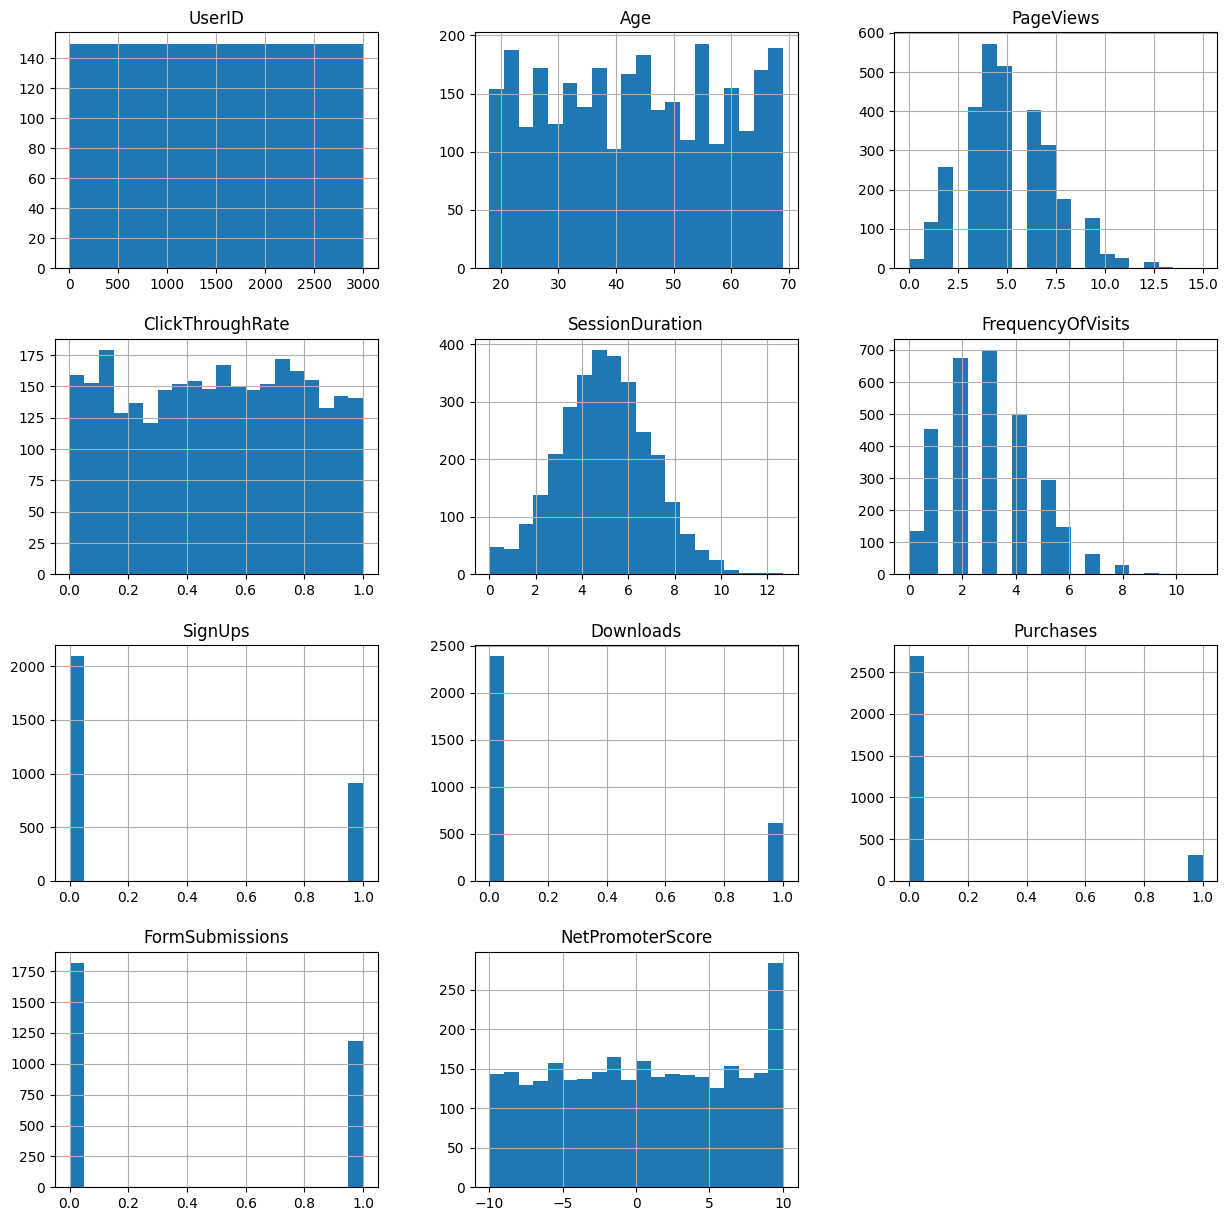

In [5]:
# Lets see the general distrubition of the numerical variables
axList = data.hist(bins=20, figsize = (15, 15))
plt.savefig("Hist.png")

In [6]:
#Check if ChatGPT correctly split the two A/B groups
data.groupby('Group')[['UserID']].count()

,UserID
Group,
Control,1500
Test,1500


In [7]:
#See if there are significant differences in the distribution of device types.
device_type = data['Device'].value_counts()

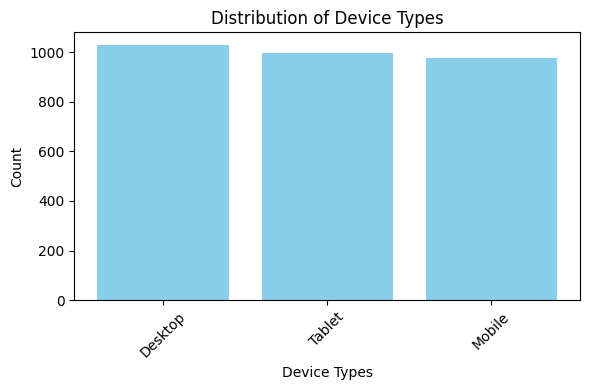

In [8]:
plt.figure(figsize=(6, 4))
plt.bar(device_type.index, device_type.values, color='skyblue')
plt.xlabel('Device Types')
plt.ylabel('Count')
plt.title('Distribution of Device Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
#Before analyzing each success metric seperately, let's look at their total as Turnover Score in a seperate column
data['Turnover_Score'] = data['SignUps'] + data['Downloads'] + data['FormSubmissions']+ data['Purchases']

The focus of this analysis will be on how the CTA Button and Color Schema affects turnover, but just for fun, let's check if device, consumed content or journey path type causes changes in turnover scores.

In [10]:
data.groupby('Device')[['Turnover_Score']].mean()

,Turnover_Score
Device,
Desktop,1.007782
Mobile,0.987705
Tablet,1.017068


In [11]:
data.groupby('ContentConsumed')[['Turnover_Score']].mean()

,Turnover_Score
ContentConsumed,
Educational,1.035433
Entertainment,1.010485
Lifestyle,0.993351
News,0.976487


In [12]:
data.groupby('UserJourneyPathway')[['Turnover_Score']].mean()

,Turnover_Score
UserJourneyPathway,
Ad Click,0.978378
Direct,1.035620
Homepage,1.004011
Search,0.998674


In [13]:
#Let's look at how turnover rates differ between the two A/B groups.
data.groupby('Group').agg({"UserID":"count", "PageViews":"mean","ClickThroughRate":"mean", "SignUps":"sum", "Downloads":"sum", "FormSubmissions":"sum", "Purchases":"sum", "Turnover_Score":"mean"})

,UserID,PageViews,ClickThroughRate,SignUps,Downloads,FormSubmissions,Purchases,Turnover_Score
Group,,,,,,,,
Control,1500,4.955333,0.494293,444,321,580,152,0.998000
Test,1500,4.911333,0.503663,464,290,603,159,1.010667


Turnover score is slightly better for the Test group, signaling a potential success of Button B and Scheme 2. However, these changes have negative results for the number of Downloads. It's a small change, but even small changes can have a large impact. But while we are certain of the difference in the data, how certain should we be that Downloads will be worse in the future if we continue with Button B and Scheme 2?

There are a couple of ways we can get at the certainty of these numbers. Next, we will use bootstrapping.

A/B Testing: Bootstrapping 
Definiton of Method


We'll use bootstrapping for A/B testing. The basic idea of bootstrapping is that inference about a population from sample data (sample → population) can be modelled by resampling the sample data and performing inference about a sample from resampled data (resampled → sample). As the population is unknown, the true error in a sample statistic against its population value is unknown. In bootstrap-resamples, the 'population' is in fact the sample, and this is known; hence the quality of inference of the 'true' sample from resampled data (resampled → sample) is measurable. This information retrieved from Wikipedia.

Testing Steps:

1. Creating 1000 samples of dataset (bootstraping)
2. Calculating SignUp, Download, Form Submission and Purchase rates for A/B groups
3. Plotting the bootstrap distributions
4. Calculating the differences between the two A/B groups
5. Calculating the probability that turnover rates are greater for the control group
6. Evaluating results and making recommendation

In [14]:
# Creating an list with bootstrapped means for each A/B group

boot_signup = []
boot_downloads = []
boot_form = []
boot_purchase = []

for i in range(1000):
    
    boot_mean_signup = data.sample(frac=1, replace=True).groupby('Group')['SignUps'].mean()
    boot_mean_downloads = data.sample(frac=1, replace=True).groupby('Group')['Downloads'].mean()
    boot_mean_form = data.sample(frac=1, replace=True).groupby('Group')['FormSubmissions'].mean()
    boot_mean_purchase = data.sample(frac=1, replace=True).groupby('Group')['Purchases'].mean()
    
    boot_signup.append(boot_mean_signup)
    boot_downloads.append(boot_mean_downloads)
    boot_form.append(boot_mean_form)
    boot_purchase.append(boot_mean_purchase)

In [15]:
# Transforming the list to a DataFrame

boot_signup = pd.DataFrame(boot_signup)
boot_downloads = pd.DataFrame(boot_downloads)
boot_form = pd.DataFrame(boot_form)
boot_purchase = pd.DataFrame(boot_purchase)

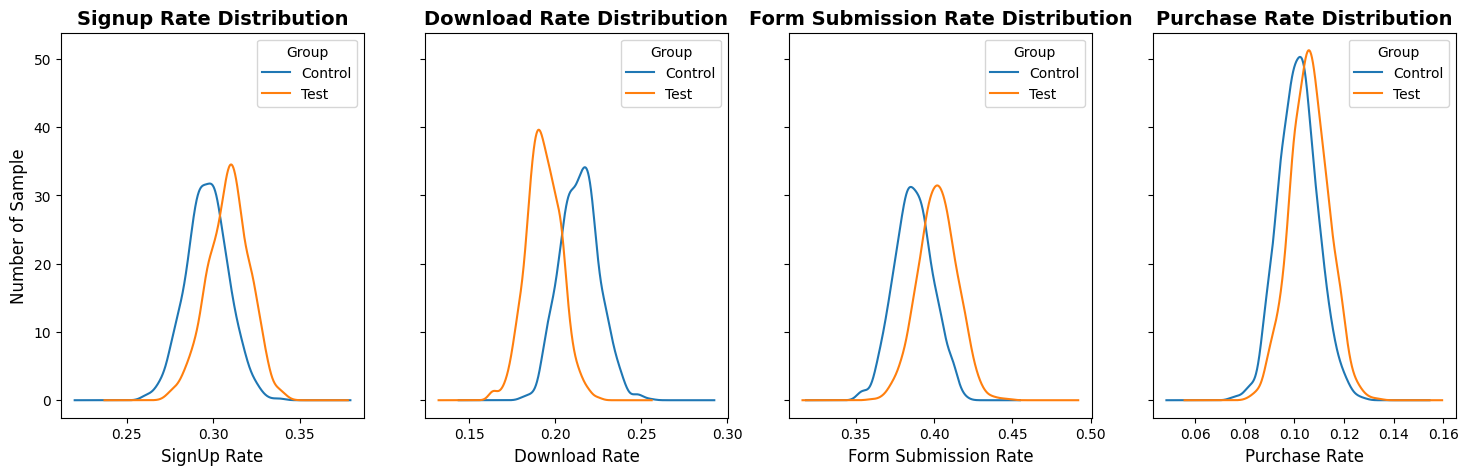

In [16]:
# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(18, 5))

boot_signup.plot.kde(ax=ax1)
ax1.set_xlabel("SignUp Rate", size=12)
ax1.set_ylabel("Number of Sample", size=12)
ax1.set_title("Signup Rate Distribution", fontweight="bold", size=14)

boot_downloads.plot.kde(ax=ax2)
ax2.set_xlabel("Download Rate", size=12)
ax2.set_ylabel("Number of Sample", size=12)
ax2.set_title("Download Rate Distribution", fontweight="bold", size=14)

boot_form.plot.kde(ax=ax3)
ax3.set_xlabel("Form Submission Rate", size=12)
ax3.set_ylabel("Number of Sample", size=12)
ax3.set_title("Form Submission Rate Distribution", fontweight="bold", size=14)

boot_purchase.plot.kde(ax=ax4)
ax4.set_xlabel("Purchase Rate", size=12)
ax4.set_ylabel("Number of Sample", size=12)
ax4.set_title("Purchase Rate Distribution", fontweight="bold", size=14)

plt.show()

These four distributions above represent the bootstrap uncertainty over what the underlying turnover rates could be for the two A/B groups. Just skimming these plots, we can see that there seems to be some evidence of a difference, albeit small. Let's zoom in on the differences.

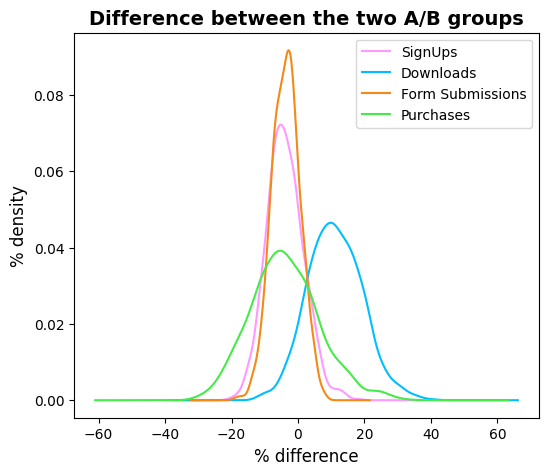

In [17]:
boot_signup['diff'] = ((boot_signup['Control'] - boot_signup['Test']) / boot_signup['Test'] * 100)
boot_downloads['diff'] = ((boot_downloads['Control'] - boot_downloads['Test']) / boot_downloads['Test'] * 100)
boot_form['diff'] = ((boot_form['Control'] - boot_form['Test']) / boot_form['Test'] * 100)
boot_purchase['diff'] = ((boot_purchase['Control'] - boot_purchase['Test']) / boot_purchase['Test'] * 100)

fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_signup['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "SignUps")
boot_downloads['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "Downloads")
boot_form['diff'].plot.kde(ax=ax1, c= "#F58917", label = "Form Submissions")
boot_purchase['diff'].plot.kde(ax=ax1, c= "#47EA4A", label = "Purchases")

ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

From these charts, we can see that the most likely % difference is around 12% - 13% for Downloads. For SignUps and Form Submissions the most likely % difference is around -2%. Lastly, for Purchases it's around -7%. Moreover, the most of the distribution is below 0%, in favor of CTA Button B and Schema 2, except for Downloads. But what is the probability that the difference is below 0%? Let's calculate that as well.

In [18]:
prob_signup = (boot_signup['diff']>0).sum()/len(boot_signup['diff'])
prob_downloads = (boot_downloads['diff']>0).sum()/len(boot_downloads['diff'])

prob_form = (boot_form['diff']>0).sum()/len(boot_form['diff'])
prob_purchase = (boot_purchase['diff']>0).sum()/len(boot_purchase['diff'])

print(f"\nThe probability of 'SignUp' is greater for the Control group: {round(prob_signup,2)*100}% "
      f"\nThe probability of 'Download' is greater for the Control group: {round(prob_downloads, 2)*100}% "
      f"\nThe probability of 'Form Submission' is greater for the Control group: {round(prob_form, 2)*100}%"
      f"\nThe probability of 'Purchase' is greater for the control Croup: {round(prob_purchase, 2)*100}%")



The probability of 'SignUp' is greater for the Control group: 23.0% 
The probability of 'Download' is greater for the Control group: 92.0% 
The probability of 'Form Submission' is greater for the Control group: 19.0%
The probability of 'Purchase' is greater for the control Croup: 34.0%


The bootstrap result tells us that there is strong evidence 90% probability that Download rate is lower when Button B and Schema 2 is demonstrated to users instead of Button A and Schema 1. The other results don't seem significant.
If we assume Download is the most important KPI, it should be decided that CTA Button A and Schema 1 should be kept.

Next, We will perform Chi Square Test to understand if there a significant change in the categorical outcomes such as Signing Up, Downloading, Filling Submission Form and Purchase with CTA Button and Color Schema change.

Null Hypothesis (H0): There is no significant difference in the proportions of SignUp, Download, Form Submission and Purchase among the groups.
Alternative Hypothesis (H1): There is a significant difference in the proportions of SignUp, Download, Form Submission and Purchase among the groups.

In [19]:
#Let's create the contingency tables
crossed_1 = pd.crosstab(data.Group, data.SignUps)
crossed_2 = pd.crosstab(data.Group, data.Downloads)
crossed_3 = pd.crosstab(data.Group, data.FormSubmissions)
crossed_4 = pd.crosstab(data.Group, data.Purchases)

In [20]:
import scipy as sp
import scipy.stats

In [21]:
x2, p, dof, expected = sp.stats.chi2_contingency(crossed_1,correction=False)

print("Chi-square: %(x2)s" %locals() )
print("p-value: %(p)s" %locals() )
print("Degree of freedom: %(dof)s" %locals() )
print(expected)

if p < 0.01:
    print("Significant at 1% level of significance")
elif p < 0.05:
    print("Significant at 5% level of significance")
else:
    print("Not significant at 5% level of significance")

Chi-square: 0.6317332232713673
p-value: 0.426720268137768
Degree of freedom: 1
[[1046.  454.]
 [1046.  454.]]
Not significant at 5% level of significance


In [22]:
x2, p, dof, expected = sp.stats.chi2_contingency(crossed_2,correction=False)

print("Chi-square: %(x2)s" %locals() )
print("p-value: %(p)s" %locals() )
print("Degree of freedom: %(dof)s" %locals() )
print(expected)

if p < 0.01:
    print("Significant at 1% level of significance")
elif p < 0.05:
    print("Significant at 5% level of significance")
else:
    print("Not significant at 5% level of significance")

Chi-square: 1.9750917838785105
p-value: 0.15990843345248562
Degree of freedom: 1
[[1194.5  305.5]
 [1194.5  305.5]]
Not significant at 5% level of significance


In [23]:
x2, p, dof, expected = sp.stats.chi2_contingency(crossed_3,correction=False)

print("Chi-square: %(x2)s" %locals() )
print("p-value: %(p)s" %locals() )
print("Degree of freedom: %(dof)s" %locals() )
print(expected)

if p < 0.01:
    print("Significant at 1% level of significance")
elif p < 0.05:
    print("Significant at 5% level of significance")
else:
    print("Not significant at 5% level of significance")

Chi-square: 0.7383074569053147
p-value: 0.39020360000825294
Degree of freedom: 1
[[908.5 591.5]
 [908.5 591.5]]
Not significant at 5% level of significance


In [24]:
x2, p, dof, expected = sp.stats.chi2_contingency(crossed_4,correction=False)

print("Chi-square: %(x2)s" %locals() )
print("p-value: %(p)s" %locals() )
print("Degree of freedom: %(dof)s" %locals() )
print(expected)

if p < 0.01:
    print("Significant at 1% level of significance")
elif p < 0.05:
    print("Significant at 5% level of significance")
else:
    print("Not significant at 5% level of significance")

Chi-square: 0.1757786576011116
p-value: 0.6750263791467721
Degree of freedom: 1
[[1344.5  155.5]
 [1344.5  155.5]]
Not significant at 5% level of significance


None of the turnover outcomes produces significant differences among Control and Test groups. Therefore, according to Chi-Square test, there is no evidence to decide whether we should select Button A or B, and Color Schema 1 or 2, based on the results of this A/B testing dataset.